In [1]:
import numpy as np
from msmbuilder.feature_selection import VarianceThreshold
from msmbuilder.decomposition import tICA
from msmbuilder.cluster import MiniBatchKMeans
from msmbuilder.msm import MarkovStateModel
from sklearn.pipeline import Pipeline
from glob import glob
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import mdtraj as md

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pa

You are still using msmtools from the deprecated Omnia channel. Please switch to conda-forge to catch future updates.
In order to do so please set conda-forge channel to highest priority by:

    conda config --add channels conda-forge

and update this package by:

    conda update msmtools




## Get data

In [2]:
traj_paths = glob('/Users/robert_arbon/Datasets/DHFR/dcds/*.dcd')
topfile = '/Users/robert_arbon/Datasets/DHFR/dhfr_top.pdb'

len(traj_paths)

400

In [3]:
trajs  = [md.load(path, top=topfile) for path in traj_paths]

## Get Trial Data

In [4]:
import pandas as pd
trial_data = pd.read_pickle('best_trials.pickl')

In [5]:
trial_data.head()

,id,feature,strategy,cluster__n_clusters,tica__n_components,tica__lag_time,variance_cut__threshold,test_scores_mean,rank
3383,15,kappa_angle,csp,221,4,246,0.000169,4.298087,89.0
3417,53,omega_tor,csp,978,9,195,0.004492,5.690354,9.0
84,89,phi-o_tor,fixed,414,10,360,0.005813,2.988939,49.0
99,104,psi_tor,fixed,652,2,216,0.000290,2.990947,24.0
122,127,psi-o_tor,fixed,184,2,101,0.008936,2.986746,98.0


## Choose trial to investigate

In [151]:
trial_data['ts_gap'] = np.nan
trial_data['ts_gap_5pc'] = np.nan
trial_data['ts_gap_95pc'] = np.nan
trial_data['state_fraction'] = np.nan
trial_data['n_csp'] = np.nan

In [154]:
strategy = 'fixed'
rank = 2.0

In [155]:
trial = trial_data.loc[(trial_data['strategy']==strategy) & (trial_data['rank']==rank), :].to_dict()
trial_idx = list(trial_data.loc[(trial_data['strategy']==strategy) & (trial_data['rank']==rank), :].index)[0]

In [156]:
trial_index = trial_data.loc[(trial_data['strategy']==strategy) & (trial_data['rank']==rank), :].index


In [157]:
froot = str(strategy)+'-'+str(int(rank))

In [158]:
trial_id = trial['id'][trial_idx]
feature= trial['feature'][trial_idx]
n_clusters = int(trial['cluster__n_clusters'][trial_idx])
n_components = int(trial['tica__n_components'][trial_idx])
lag_time = int(trial['tica__lag_time'][trial_idx])
var_cut = float(trial['variance_cut__threshold'][trial_idx])


In [159]:
print('Trial ID        {}'.format(trial_id))
print('Feature         {}'.format(feature))
print('n_clusters      {}'.format(n_clusters))
print('n_components    {}'.format(n_components))
print('lag_time        {}'.format(lag_time))
print('variance cutoff {}'.format(var_cut))

Trial ID        2283
Feature         kappa_angle
n_clusters      255
n_components    2
lag_time        430
variance cutoff 0.0007977015943187404


## Filter the trajectories using MSMBuilder

In [160]:
from msmbuilder.featurizer import *
features = {'alpha_angle': AlphaAngleFeaturizer(),
            'kappa_angle': KappaAngleFeaturizer(),
            'ppo_tor': DihedralFeaturizer(types=['phi', 'psi', 'omega']),
            'pp_tor': DihedralFeaturizer(types=['phi', 'psi']),
            'phi-o_tor': DihedralFeaturizer(types=['phi', 'omega']),
            'psi-o_tor': DihedralFeaturizer(types=['psi', 'omega']),
            'phi_tor': DihedralFeaturizer(types=['phi']),
            'psi_tor': DihedralFeaturizer(types=['psi']),
            'omega_tor': DihedralFeaturizer(types=['omega'])}

In [161]:
featurizer = features[feature]
ftrajs = featurizer.fit_transform(trajs)

In [163]:
# Check for NaNs
traj_mask = [not np.any(np.isnan(ftraj)) for ftraj in ftrajs]

In [164]:
trajs = [traj for i, traj in enumerate(trajs) if traj_mask[i]]

In [165]:
traj_paths = [path for i, path in enumerate(traj_paths) if traj_mask[i]]

In [166]:
ftrajs = [ftraj for i, ftraj in enumerate(ftrajs) if traj_mask[i]]

In [167]:
variance = VarianceThreshold(threshold=var_cut)
variance.fit(ftrajs)
feat_mask = variance.get_support()

## Create pyEmma featurizer

In [168]:
def pyemma_featurizer(traj, mask, feat):
    ftraj = feat.partial_transform(traj)
    ftraj = ftraj[:, mask]
    return ftraj

In [169]:
from pyemma.coordinates.data import CustomFeature
my_feature = CustomFeature(pyemma_featurizer, mask=feat_mask, feat=featurizer, dim=int(np.sum(feat_mask)))

In [170]:
feat = coor.featurizer(topfile)

In [171]:
feat.add_custom_feature(my_feature)

In [172]:
inp = coor.source(traj_paths, feat)
print('number of trajectories = ',inp.number_of_trajectories())
print('trajectory length = ',inp.trajectory_length(0))
print('trajectory time step = ',1000.0 / (inp.trajectory_length(0)-1),'ns')
print('number of dimension = ',inp.dimension())

number of trajectories =  396
trajectory length =  1000
trajectory time step =  1.001001001001001 ns
number of dimension =  143


## tICA 

In [173]:
tica_obj = coor.tica(inp, lag=lag_time, dim=n_components, kinetic_map=True)


In [174]:
for i in range(2):
    if tica_obj.eigenvectors[0, i] > 0:
        tica_obj.eigenvectors[:, i] *= -1

In [175]:
Y = tica_obj.get_output() # get tica coordinates
print('number of trajectories = ', np.shape(Y)[0])
print('number of frames = ', np.shape(Y)[1])
print('number of dimensions = ',np.shape(Y)[2])

number of trajectories =  396
number of frames =  1000
number of dimensions =  2


/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


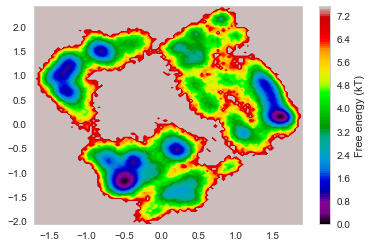

In [176]:
%matplotlib inline
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1]);


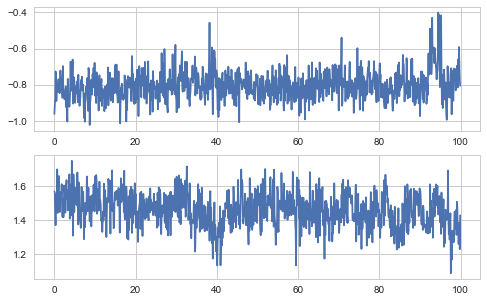

In [177]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 14})
dt = 0.1
plt.figure(figsize=(8,5))
ax1=plt.subplot(211)
x = dt*np.arange(Y[0].shape[0])
plt.plot(x, Y[2][:,0]); ylabel=('IC 1'); xticks=([]); yticks=(np.arange(-8, 4, 2))
ax1=plt.subplot(212)
plt.plot(x, Y[2][:,1]); ylabel=('IC 2'); xticks=([]);  yticks=(np.arange(-6, 4, 2))


## Clustering

In [178]:
clustering = coor.cluster_mini_batch_kmeans(Y,k=n_clusters, max_iter=1000)


03-09-17 10:49:27 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5] INFO     Cluster centers converged after 90 steps.


In [179]:
dtrajs = clustering.dtrajs


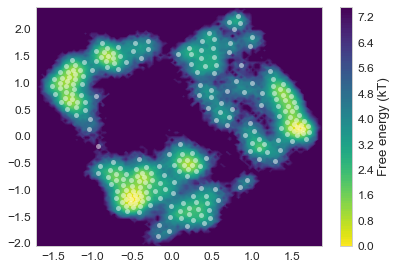

In [180]:
import seaborn as sns
with sns.plotting_context('paper', font_scale=1.5):
    mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1], cmap='viridis_r')
    cc_x = clustering.clustercenters[:,0]
    cc_y = clustering.clustercenters[:,1]
    plt.plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='white', alpha=0.5)

## Estimate MSM

In [181]:
msm_lag = 50
M = msm.bayesian_markov_model(dtrajs, msm_lag)
print('fraction of states used = ', M.active_state_fraction)
print('fraction of counts used = ', M.active_count_fraction)

fraction of states used =  1.0
fraction of counts used =  1.0


In [182]:
trial_data.loc[trial_index, 'state_fraction'] = M.active_state_fraction

In [210]:
from msmbuilder.msm import BayesianMarkovStateModel, MarkovStateModel
mm = BayesianMarkovStateModel(lag_time=50)
mm.fit(dtrajs)

BayesianMarkovStateModel(ergodic_cutoff='on', lag_time=50, n_chains=None,
             n_samples=100, n_steps=0, n_timescales=None, prior_counts=0,
             random_state=None, reversible=True, sampler='metzner',
             sliding_window=True, verbose=False)

In [211]:
mle_mm = MarkovStateModel(lag_time=50)
mle_mm.fit(dtrajs)

MSM contains 1 strongly connected component above weight=0.02. Component 0 selected, with population 100.000000%


MarkovStateModel(ergodic_cutoff='on', lag_time=50, n_timescales=None,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         use_gap=None, verbose=True)

## Timescales

In [184]:
import pandas as pd
ts_df = pd.DataFrame(data=mm.all_timescales_[:,:10])
ts_df.head()

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/msmbuilder-3.9.0.dev0-py3.5-macosx-10.6-x86_64.egg/msmbuilder/msm/bayesmsm.py:326: RuntimeWarning: invalid value encountered in log
  timescales = - self.lag_time / np.log(us[:, 1:])


,0,1,2,3,4,5,6,7,8,9
0,132849.895711,102998.230308,9426.664992,3629.062317,2503.860455,1968.776125,1613.882169,1352.685174,997.163640,605.822290
1,133593.544452,103781.943635,9443.252920,3628.740946,2532.616001,1942.119161,1620.507945,1351.019754,1008.649591,605.678593
2,27239.225286,23858.228037,3361.624380,2775.534150,1413.100214,932.531072,789.046436,716.699664,500.919353,433.400232
3,27957.240174,19220.865612,2238.095840,943.612379,747.599709,707.654184,547.973675,488.542260,400.987457,343.193717
4,15348.516841,13447.925622,1800.227474,778.163950,537.357912,526.323239,378.546460,325.579426,271.817899,211.032993


In [185]:
ts_df = pd.melt(ts_df, var_name='Process', value_name='Timescale')
ts_df['Process'] += 1
ts_df.head()

,Process,Timescale
0,1,132849.895711
1,1,133593.544452
2,1,27239.225286
3,1,27957.240174
4,1,15348.516841


In [186]:
med_ts = ts_df.groupby('Process').aggregate(np.median).values.flatten()

In [187]:
ratios = med_ts[:-1]/med_ts[1:]
med_gap = np.max(ratios)
sup_proc = np.argmax(ratios)+1
print('Gap is {:4.2f}'.format(med_gap))
print('Slow processes are {}'.format(np.arange(sup_proc)+1))
ts_df['Classification'] = ts_df['Process'].apply(lambda x: 'Fast' if x > sup_proc else 'Slow')
ts_df['Timescale'] /= 1e3

Gap is 5.85
Slow processes are [1 2]


In [188]:
slowest_fast = ts_df.loc[ts_df['Process']==sup_proc+1, 'Timescale'].values
fastest_slow = ts_df.loc[ts_df['Process']==sup_proc, 'Timescale'].values

In [189]:
n_samples = int(1e5)
gaps = np.zeros(n_samples)
for i in range(n_samples):
    fast = np.random.choice(slowest_fast, size=1)
    slow = np.random.choice(fastest_slow, size=1)
    gaps[i] = slow/fast
    

In [190]:
gaps_df = pd.DataFrame(data={'Gaps': gaps})


In [191]:
trial_data.loc[trial_index, 'ts_gap'] = np.median(gaps)
trial_data.loc[trial_index, 'ts_gap_5pc'] = np.percentile(gaps, 5)
trial_data.loc[trial_index, 'ts_gap_95pc'] = np.percentile(gaps, 95)
trial_data.loc[trial_index, 'n_csp']= sup_proc

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


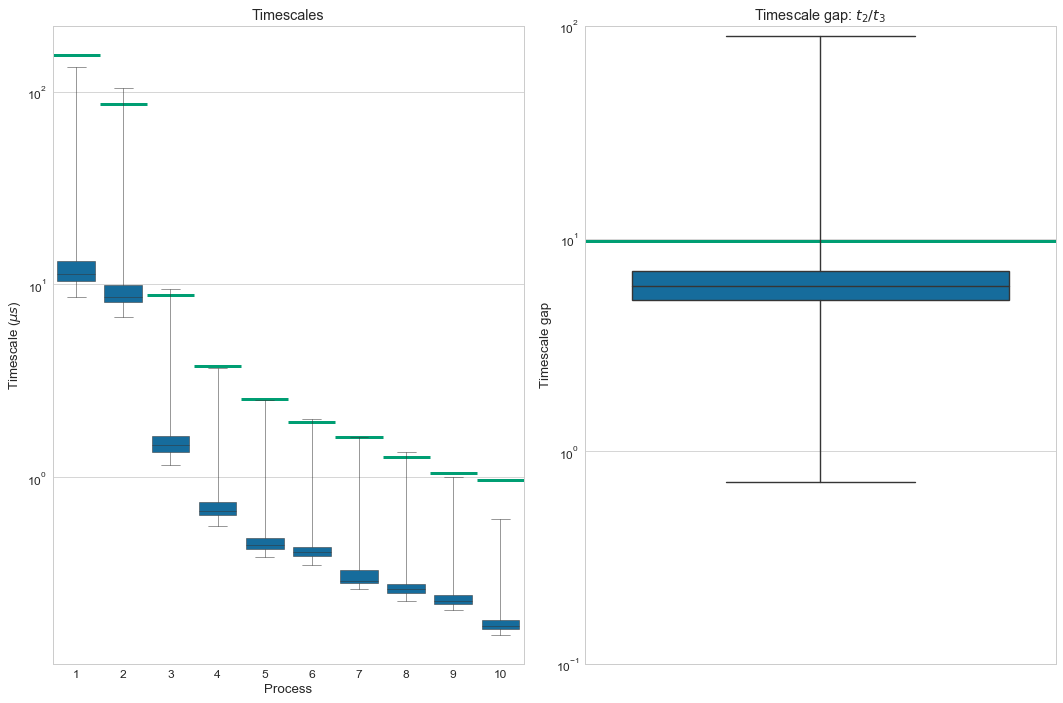

In [238]:
cols = sns.color_palette('colorblind')
with sns.plotting_context('paper', font_scale=1.5):
    # plot all timescales
    fig, axes = plt.subplots(1, 2, figsize=(15,10))
    sns.set_style('whitegrid')
    cols = sns.color_palette('colorblind')
    
    ax = sns.boxplot(x='Process', y='Timescale', data=ts_df, whis=100,
                    linewidth=0.5, ax=axes[0], color=cols[0])
    for i in range(10):
        ax.hlines(mle_mm.timescales_[i]/1000, i-0.5, i+0.5, color=cols[1], lw=3)
    ax.set_yscale('log')
    ax.set_ylabel(r'Timescale ($\mu s$)')
    ax.set_title('Timescales')
    
    ax.legend()
#     ax.legend(handles=[h[0], h /[10]], labels=['Bayesian', 'MLE'])

    ax2 = sns.boxplot(y='Gaps', data=gaps_df, whis=100, ax=axes[1], color=cols[0])
    ax2.set_ylabel('Timescale gap')
    ax2.set_yscale('log')
    ax2.set_ylim((0.1,100))
    ax2.set_title('Timescale gap: $t_{%d}/t_{%d}$' % (sup_proc, sup_proc+1) )
    
    gap = np.max(mle_mm.timescales_[:9]/mle_mm.timescales_[1:10])
    ax2.hlines(gap, -0.5, 0.5, color=cols[1], lw=3)
#     for i in range(10):
#         axes[2].hlines(mle_mm.timescales_[i], 0, 1)
    
#     axes[2].set_yscale('log')
    
    plt.tight_layout()
plt.savefig('msm_figures/'+froot+'-timescales.pdf')

## Coarse Grain

In [193]:
n_sets = sup_proc+1
M.pcca(n_sets)
pcca_dist = M.metastable_distributions
membership = M.metastable_memberships  
active_set = M.active_set
# Need to take into account unassigned states! 
# get PCCA memberships
# memberships over trajectory
# dist_all = [np.hstack([pcca_dist[i,:][dtraj] if dtraj in active_set else np.nan for dtraj in M.discrete_trajectories_full]) 
#             for i in range(n_sets)]
# mem_all = [np.hstack([membership[:,i][dtraj] if dtraj in active_set else np.nan for dtraj in M.discrete_trajectories_full]) 
#            for i in range(n_sets)]

In [194]:
pcca_samples = M.sample_by_distributions(pcca_dist, 100)

In [195]:
output_files = ['metastable_states/'+froot+'-pcca{}.xtc'.format(i+1) for i in range(n_sets)]
output_files

['metastable_states/fixed-2-pcca1.xtc',
 'metastable_states/fixed-2-pcca2.xtc',
 'metastable_states/fixed-2-pcca3.xtc']

In [196]:
coor.save_trajs(inp, pcca_samples, outfiles=output_files)

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/mdtraj/utils/unitcell.py:97: RuntimeWarning: invalid value encountered in greater
  a[np.logical_and(a>-tol, a<tol)] = 0.0
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/mdtraj/utils/unitcell.py:97: RuntimeWarning: invalid value encountered in less
  a[np.logical_and(a>-tol, a<tol)] = 0.0
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/mdtraj/utils/unitcell.py:98: RuntimeWarning: invalid value encountered in greater
  b[np.logical_and(b>-tol, b<tol)] = 0.0
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/mdtraj/utils/unitcell.py:98: RuntimeWarning: invalid value encountered in less
  b[np.logical_and(b>-tol, b<tol)] = 0.0
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/mdtraj/utils/unitcell.py:99: RuntimeWarning: invalid value encountered in greater
  c[np.logical_and(c>-tol, c<tol)] = 0.0
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/p

['metastable_states/fixed-2-pcca1.xtc',
 'metastable_states/fixed-2-pcca2.xtc',
 'metastable_states/fixed-2-pcca3.xtc']

## Hidden Markov Model

In [197]:
hmm = msm.estimate_hidden_markov_model(dtrajs, nstates=n_sets, lag=50, connectivity='all')

In [198]:
hmm.stationary_distribution

array([ 0.44444444,  0.24494949,  0.31060606])

In [199]:
hmm.P

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])

## Assignment of states

In [200]:
# ax = plt.subplot2grid((2, 2), (0, 0))
# ax = plt.subplot(2, 2, 1)


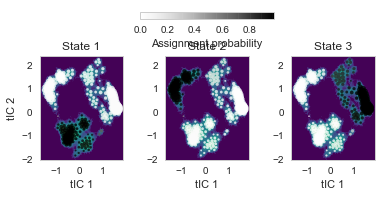

In [201]:
import seaborn as sns
from matplotlib.ticker import *
import matplotlib.gridspec as gridspec

# with sns.plotting_context('paper', font_scale=1.5):
    
fig = plt.figure()

nrows = 2
ncols = n_sets

gs = gridspec.GridSpec(nrows, ncols, height_ratios=[0.05,1])
plot_axes = [plt.subplot(gs[1,i]) for i in range(ncols)]
cb_axes = plt.subplot(gs[0,:])


for i, ax in enumerate(plot_axes):
    use_cbar = i==0
    mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1], cmap='viridis_r', ax=ax, cbar=False)

    cc_x = clustering.clustercenters[active_set,0]
    cc_y = clustering.clustercenters[active_set,1]
    cax = ax.scatter(cc_x,cc_y, marker='o', 
                s=1.5*M.pi/np.min(M.pi), 
                c=membership.T[i], 
                alpha=0.8)
    ax.set(aspect='equal')
    ax.set_title('State {}'.format(i+1))
    if i == 0:
        ax.set_ylabel('tIC 2')
    ax.set_xlabel('tIC 1')

cb_axes.axis('off')
cb = fig.colorbar(cax, ax=cb_axes, label='Assignment probability', orientation='horizontal', fraction=1, shrink=0.4)
fig.subplots_adjust(wspace=0.5, hspace=-0.3)
plt.savefig('msm_figures/'+froot+'-metastable_states.pdf')


## Eigenvectors

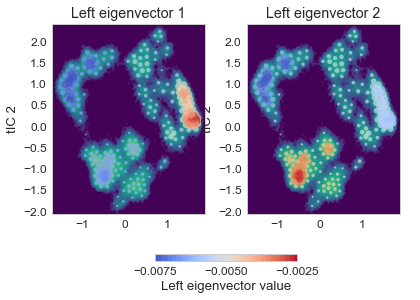

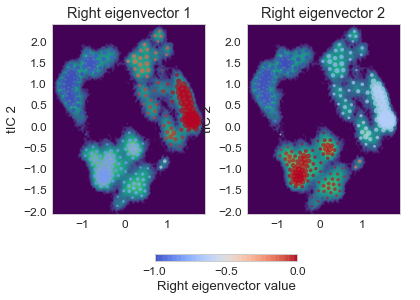

In [202]:
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

with sns.plotting_context('paper', font_scale=1.5):
    
    for vec in ['Left', 'Right']:
    
#         fig, axes = plt.subplots(1,n_sets-1,  sharex=True, sharey=True, figsize=(5,12))
        
        fig = plt.figure()

        nrows = 2
        ncols = n_sets-1

        gs = gridspec.GridSpec(nrows, ncols, height_ratios=[1,0.05], hspace=0.4)
        plot_axes = [plt.subplot(gs[0,i]) for i in range(ncols)]
        cb_axes = plt.subplot(gs[1,:])
    
        for i, ax in enumerate(plot_axes):
            mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1], cmap='viridis_r', ax=ax, cbar=False)

            cc_x = clustering.clustercenters[active_set,0]
            cc_y = clustering.clustercenters[active_set,1]
            
            if vec=='Left':
                eigvecs = M.eigenvectors_left()[i+1]
                
            elif vec=='Right':
                eigvecs = M.eigenvectors_right().T[i+1]

            cax = ax.scatter(cc_x,cc_y, marker='o', 
                        s=2*M.pi/np.min(M.pi), 
                        c=eigvecs, 
                        alpha=0.7, 
                        cmap="coolwarm")
            ax.set(adjustable='box-forced', aspect='equal')
            if i == n_sets-1:
                ax.set_xlabel('tIC 1')
            ax.set_ylabel('tIC 2')
            ax.set_title('{0} eigenvector {1}'.format(vec, i+1))
        # color bar
        
        cb_axes.axis('off')
        cbar = fig.colorbar(cax, ax=cb_axes, orientation='horizontal', 
                            fraction=1, shrink=0.4)
        cbar.set_label(label='{} eigenvector value'.format(vec))
        locator = LinearLocator(numticks=3)
        cbar.ax.xaxis.set_major_locator(locator)
        plt.savefig('msm_figures/'+froot+'-{}-eigenvectors.pdf'.format(vec))

